Iteration 10/120, Best ROI: 371015.82, Avg: 286310.60
Iteration 20/120, Best ROI: 371015.82, Avg: 290910.24
Iteration 30/120, Best ROI: 371015.82, Avg: 292177.69
Iteration 40/120, Best ROI: 371015.82, Avg: 288241.81
Iteration 50/120, Best ROI: 371015.82, Avg: 291495.29
Iteration 60/120, Best ROI: 371015.82, Avg: 290534.63
Iteration 70/120, Best ROI: 371015.82, Avg: 297057.88
Iteration 80/120, Best ROI: 371015.82, Avg: 296117.55
Iteration 90/120, Best ROI: 371015.82, Avg: 301642.98
Iteration 100/120, Best ROI: 371015.82, Avg: 304029.47
Iteration 110/120, Best ROI: 371015.82, Avg: 304806.16
Iteration 120/120, Best ROI: 371015.82, Avg: 306265.00

Optimal Budget Allocation:
Social Media: $55000.00 (ROI: 5.25, Return: $288557.19)
TV: $20000.00 (ROI: 1.18, Return: $23657.74)
Radio: $20000.00 (ROI: 2.21, Return: $44147.84)
Email: $5000.00 (ROI: 2.93, Return: $14653.05)
Total Budget: $100000.00
Total Return: $371015.82
Overall ROI: 3.71


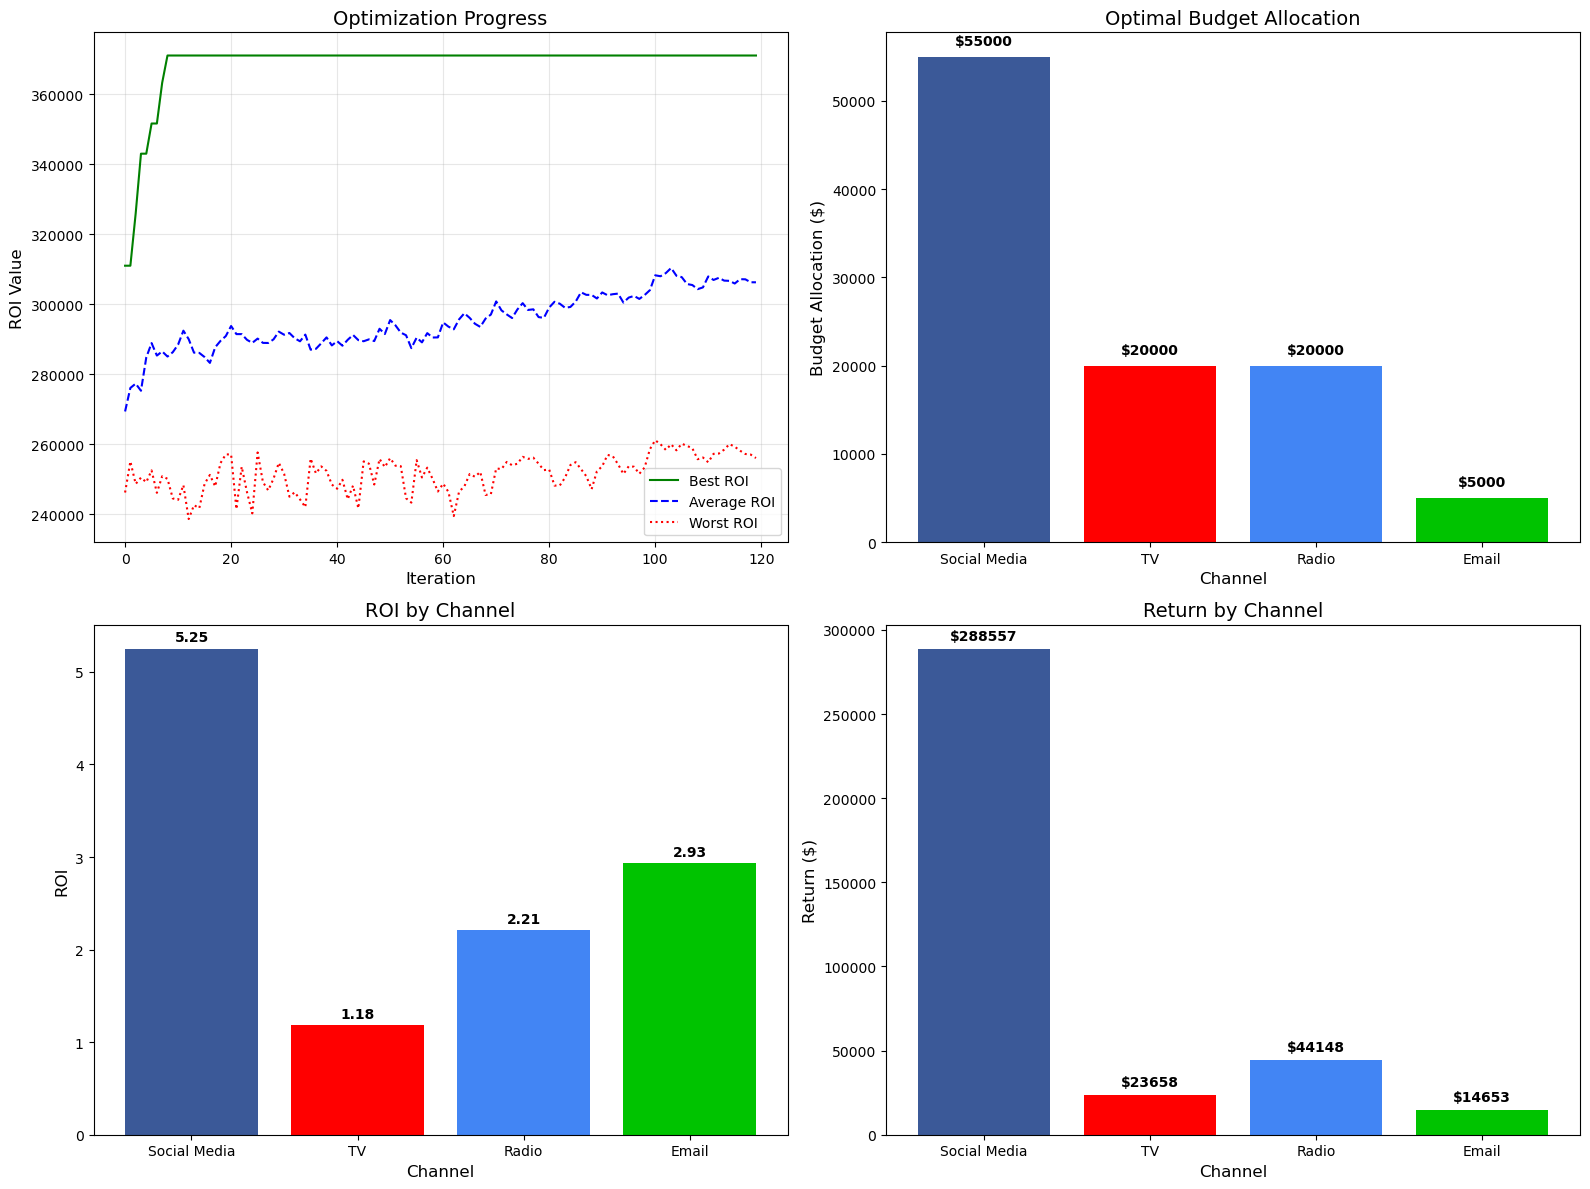

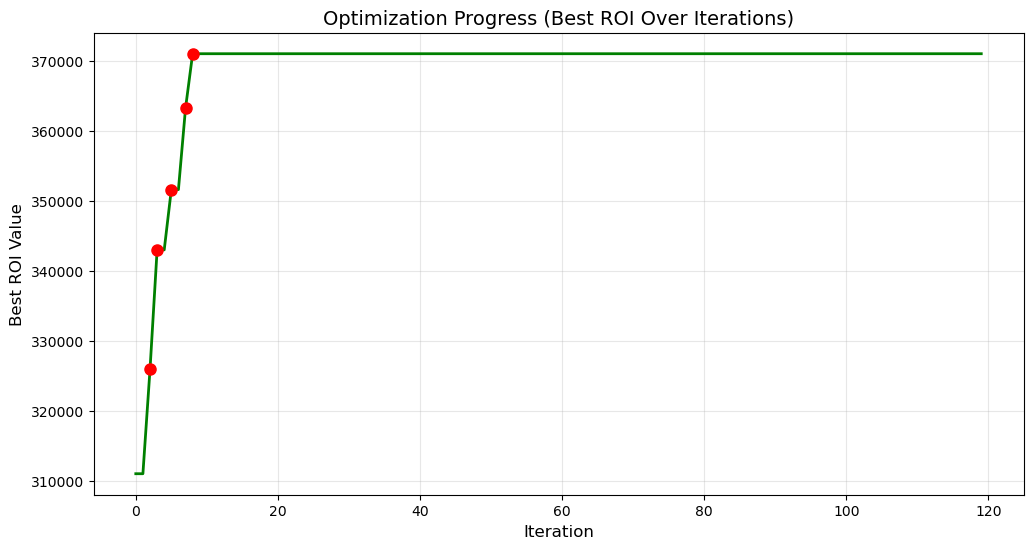

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

class MarketingBudgetProblem:
    def __init__(self, total_budget=100000, min_spends=None):
        self.total_budget = total_budget
        self.min_spends = min_spends or [5000, 10000, 5000, 2000]  # Min spend for [Social, TV, Radio, Email]
        self.channels = ["Social Media", "TV", "Radio", "Email"]
        
    def roi_function(self, allocation):
        """
        Calculate ROI for each channel based on allocation
        
        The ROI functions model:
        - Social Media: Diminishing returns (logarithmic)
        - TV: S-curve (sigmoid) - needs critical mass to be effective
        - Radio: Close to linear with slight diminishing returns
        - Email: High ROI at low spend but quickly saturates
        """
        social_roi = 2.3 * np.log(1 + allocation[0] / 8000) + 0.5
        tv_roi = 2.2 * (1 / (1 + np.exp(-0.00008 * (allocation[1] - 25000)))) + 0.3
        radio_roi = 0.7 * np.sqrt(allocation[2] / 3000) + 0.4
        email_roi = 3.0 * (1 - np.exp(-0.0003 * allocation[3])) + 0.6
        
        social_return = allocation[0] * social_roi
        tv_return = allocation[1] * tv_roi
        radio_return = allocation[2] * radio_roi
        email_return = allocation[3] * email_roi
        
        return np.array([social_return, tv_return, radio_return, email_return])
    
    def evaluate(self, allocation):
        """
        Evaluate the fitness of an allocation solution
        Returns negative total return for minimization problem
        """
        if not self.is_valid_allocation(allocation):
            return -np.inf  # Invalid solution
    
        returns = self.roi_function(allocation)
        total_return = np.sum(returns)
        
        return total_return
    
    def is_valid_allocation(self, allocation):
        """
        Check if allocation meets all constraints:
        1. All allocations are non-negative
        2. Each channel gets at least its minimum spend
        3. Total allocation equals the total budget
        """
        for i, amount in enumerate(allocation):
            if amount < self.min_spends[i]:
                return False
        
        if not np.isclose(np.sum(allocation), self.total_budget, rtol=1e-5):
            return False
            
        return True
    
    def fix_allocation(self, allocation):
        """
        Adjust an invalid allocation to make it valid:
        1. Ensure minimum spends
        2. Scale to match total budget
        """
        for i in range(len(allocation)):
            allocation[i] = max(allocation[i], self.min_spends[i])
        
        total_allocated = np.sum(allocation)
        
        min_total = sum(self.min_spends)
        if min_total > self.total_budget:
            raise ValueError("Total budget is less than sum of minimum spends")
        
        excess = allocation - self.min_spends
        total_excess = np.sum(excess)
        
        remaining_budget = self.total_budget - min_total
        if total_excess > 0:
            scaling_factor = remaining_budget / total_excess
            adjusted_excess = excess * scaling_factor
            allocation = self.min_spends + adjusted_excess
        
        return allocation

class FireflyAlgorithm:
    def __init__(self, problem, n_fireflies=20, max_iter=100, alpha=0.5, beta_0=1.0, gamma=1.0):
        self.problem = problem
        self.n_fireflies = n_fireflies  # Increased number of fireflies
        self.max_iter = max_iter
        self.alpha = alpha  # Higher initial randomization parameter
        self.beta_0 = beta_0  # Attractiveness at distance=0
        self.gamma = gamma  # Light absorption coefficient
        self.dim = len(problem.channels)
        
        self.fireflies = self._initialize_fireflies()
        self.intensities = np.array([problem.evaluate(firefly) for firefly in self.fireflies])
        
        self.best_solution = self.fireflies[np.argmax(self.intensities)].copy()
        self.best_intensity = np.max(self.intensities)
        
    def _initialize_fireflies(self):
        """Initialize fireflies with diverse strategies to cover solution space better"""
        fireflies = []
        
        allocation = np.array(self.problem.min_spends, dtype=float)
        remaining = self.problem.total_budget - np.sum(allocation)
        equal_remaining = remaining / self.dim
        equal_allocation = allocation + equal_remaining
        fireflies.append(self.problem.fix_allocation(equal_allocation))
        
        for i in range(self.dim):
            channel_heavy = allocation.copy()
            channel_heavy[i] += remaining * 0.7  # 70% to one channel
            remaining_small = remaining * 0.3
            for j in range(self.dim):
                if j != i:
                    channel_heavy[j] += remaining_small / (self.dim - 1)
            fireflies.append(self.problem.fix_allocation(channel_heavy))
   
        for _ in range(self.n_fireflies - self.dim - 1):
            if _ % 3 == 0:

                random_props = np.random.rand(self.dim)
            elif _ % 3 == 1:
          
                random_props = np.random.power(0.5, self.dim)
            else:
                
                random_props = np.abs(np.random.normal(0.5, 0.25, self.dim))
                
            random_props = random_props / np.sum(random_props)
            rand_allocation = allocation + random_props * remaining
            fireflies.append(self.problem.fix_allocation(rand_allocation))
            
        return np.array(fireflies)
        
    def move_firefly(self, i, j):
        """
        Move firefly i toward brighter firefly j with improved movement strategy
        """
        if self.intensities[j] > self.intensities[i]:
            r = np.linalg.norm(self.fireflies[i] - self.fireflies[j])
            beta = self.beta_0 * np.exp(-self.gamma * r**2)
            
            random_step = self.alpha * (np.random.rand(self.dim) - 0.5) * self.problem.total_budget * 0.2
            
            self.fireflies[i] = self.fireflies[i] + \
                               beta * (self.fireflies[j] - self.fireflies[i]) + \
                               random_step
            
            self.fireflies[i] = self.problem.fix_allocation(self.fireflies[i])
            
            self.intensities[i] = self.problem.evaluate(self.fireflies[i])
    
    def optimize(self):
        """Run the Firefly Algorithm optimization with improved tracking"""
        history = {'best': [], 'avg': [], 'worst': []}
        
        alpha_schedule = np.linspace(self.alpha, 0.05, self.max_iter)  # Linear cooling schedule
        
        for t in range(self.max_iter):
            
            self.alpha = alpha_schedule[t]
            
            for i in range(self.n_fireflies):
            
                for j in range(self.n_fireflies):
                    if i != j:
                        self.move_firefly(i, j)
            
            current_best_idx = np.argmax(self.intensities)
            if self.intensities[current_best_idx] > self.best_intensity:
                self.best_intensity = self.intensities[current_best_idx]
                self.best_solution = self.fireflies[current_best_idx].copy()
            
            if t % 5 == 0 and t > 0:
                worst_idx = np.argmin(self.intensities)
                allocation = np.array(self.problem.min_spends, dtype=float)
                remaining = self.problem.total_budget - np.sum(allocation)
                random_props = np.random.rand(self.dim)
                random_props = random_props / np.sum(random_props)
                self.fireflies[worst_idx] = allocation + random_props * remaining
                self.fireflies[worst_idx] = self.problem.fix_allocation(self.fireflies[worst_idx])
                self.intensities[worst_idx] = self.problem.evaluate(self.fireflies[worst_idx])
            
            if t % 10 == 0 and t > 0:
                random_idx = np.random.randint(0, self.n_fireflies)
                self.fireflies[random_idx] = self.best_solution.copy()
                self.intensities[random_idx] = self.best_intensity
            
            avg_intensity = np.mean(self.intensities)
            worst_intensity = np.min(self.intensities)
            
            history['best'].append((t, self.best_intensity))
            history['avg'].append((t, avg_intensity))
            history['worst'].append((t, worst_intensity))
            
            if (t+1) % 10 == 0:
                print(f"Iteration {t+1}/{self.max_iter}, Best ROI: {self.best_intensity:.2f}, Avg: {avg_intensity:.2f}")
        
        return self.best_solution, self.best_intensity, history

def optimize_marketing_budget(total_budget=100000, min_spends=None, visualize=True):
    problem = MarketingBudgetProblem(total_budget, min_spends)
    
    fa = FireflyAlgorithm(problem, n_fireflies=40, max_iter=120)
    
    best_allocation, best_roi, history = fa.optimize()
    
    channel_returns = problem.roi_function(best_allocation)
    channel_rois = channel_returns / best_allocation
    
    print("\nOptimal Budget Allocation:")
    for i, channel in enumerate(problem.channels):
        print(f"{channel}: ${best_allocation[i]:.2f} (ROI: {channel_rois[i]:.2f}, Return: ${channel_returns[i]:.2f})")
    print(f"Total Budget: ${np.sum(best_allocation):.2f}")
    print(f"Total Return: ${np.sum(channel_returns):.2f}")
    print(f"Overall ROI: {np.sum(channel_returns)/np.sum(best_allocation):.2f}")
    
    if visualize:
        plt.figure(figsize=(16, 12))
        
        plt.subplot(2, 2, 1)
        best_iterations, best_values = zip(*history['best'])
        avg_iterations, avg_values = zip(*history['avg'])
        worst_iterations, worst_values = zip(*history['worst'])
        
        plt.plot(best_iterations, best_values, 'g-', label='Best ROI')
        plt.plot(avg_iterations, avg_values, 'b--', label='Average ROI')
        plt.plot(worst_iterations, worst_values, 'r:', label='Worst ROI')
        
        plt.title('Optimization Progress', fontsize=14)
        plt.xlabel('Iteration', fontsize=12)
        plt.ylabel('ROI Value', fontsize=12)
        plt.grid(True, alpha=0.3)
        plt.legend()
        
        plt.subplot(2, 2, 2)
        colors = ['#3b5998', '#FF0000', '#4285F4', '#00c300']
        bars = plt.bar(problem.channels, best_allocation, color=colors)
        plt.title('Optimal Budget Allocation', fontsize=14)
        plt.xlabel('Channel', fontsize=12)
        plt.ylabel('Budget Allocation ($)', fontsize=13)
        
        for bar in bars:
            height = bar.get_height()
            plt.text(bar.get_x() + bar.get_width()/2., height + 0.01*total_budget,
                    f'${height:.0f}',
                    ha='center', va='bottom', fontweight='bold')
        
        plt.subplot(2, 2, 3)
        bars = plt.bar(problem.channels, channel_rois, color=colors)
        plt.title('ROI by Channel', fontsize=14)
        plt.xlabel('Channel', fontsize=12)
        plt.ylabel('ROI', fontsize=12)
        
        for bar in bars:
            height = bar.get_height()
            plt.text(bar.get_x() + bar.get_width()/2., height + 0.05,
                    f'{height:.2f}',
                    ha='center', va='bottom', fontweight='bold')
        
        plt.subplot(2, 2, 4)
        bars = plt.bar(problem.channels, channel_returns, color=colors)
        plt.title('Return by Channel', fontsize=14)
        plt.xlabel('Channel', fontsize=12)
        plt.ylabel('Return ($)', fontsize=12)
        
        for bar in bars:
            height = bar.get_height()
            plt.text(bar.get_x() + bar.get_width()/2., height + 0.01*np.sum(channel_returns),
                    f'${height:.0f}',
                    ha='center', va='bottom', fontweight='bold')
        
        plt.tight_layout()
        plt.show()
        
        plt.figure(figsize=(12, 6))
        plt.plot(best_iterations, best_values, 'g-', linewidth=2, label='Best ROI')
        plt.title('Optimization Progress (Best ROI Over iterations)', fontsize=14)
        plt.xlabel('Iteration', fontsize=12)
        plt.ylabel('Best ROI Value', fontsize=12)
        plt.grid(True, alpha=0.3)
        
        significant_points = []
        for i in range(1, len(best_values)):
            if i > 1 and best_values[i] > best_values[i-1] + 0.01:
                significant_points.append(i)
                
        plt.plot([best_iterations[i] for i in significant_points], 
                 [best_values[i] for i in significant_points], 
                 'ro', markersize=8)
        
        plt.show()
    
    return best_allocation, best_roi

if __name__ == "__main__":
    # Define problem parameters
    total_budget = 100000  
    min_spends = [1000, 20000, 20000, 5000]  
    

    best_allocation, best_roi = optimize_marketing_budget(total_budget, min_spends)